In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
# import moss
import csv
import random
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from matplotlib.ticker import PercentFormatter
from statsmodels.stats.anova import AnovaRM
from sklearn.preprocessing import StandardScaler
from matplotlib.cm import get_cmap
from plot_utils import combined_rolling_average_and_model_fit, combined_sliding_window_and_model_fit_split_col
from common_functions import remove_unit_variance

In [2]:
scaler = StandardScaler()

df = pd.read_csv('pilot_total.csv')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df_cleaned = pd.read_csv('pilot_total_errors.csv')


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_21157/45566082.py:3: DtypeWarning: Columns (254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('pilot_total.csv')
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_21157/45566082.py:5: DtypeWarning: Columns (157,254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv('pilot_total_errors.csv')


In [3]:
# df_cleaned['wm_untested_choice_num']

In [4]:
df['it_pos_neg'] =  np.where(df['it_sim_dis_diff_test'] <= 0, 0, 1)
df['v2_pos_neg'] =  np.where(df['v2_sim_dis_diff_test'] <= 0, 0, 1)
df_correct = df[df['resp_correct'] == 1]
#this approach here seems more correct
df_correct['wm_rt'] = df_correct['mouse.time_last'] * 1000
# df_correct['wm_rt'] = np.log(df_correct['wm_rt'])
df_correct = remove_unit_variance(df_correct,'wm_rt', 'participant')
df_correct['WM RT'] = df_correct['wm_rt']


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_21157/2543274082.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct['wm_rt'] = df_correct['mouse.time_last'] * 1000


In [5]:
df_correct['WM RT']

0        1694.9
2         894.8
3        2095.7
5         895.8
8        1261.2
          ...  
80630    1430.0
80631    2181.0
80632    2562.0
80633    2031.0
80635    2164.0
Name: WM RT, Length: 60219, dtype: float64

In [6]:
sns.set_context('notebook')

In [7]:

blue = '#90BDEC'
gray = '#BFBFBF'

# Create a palette list
palette = [blue, gray]
sns.set_palette(palette)  # Set as default palette


In [8]:
df_cleaned['Error Category Accuracy'] = df_cleaned['wm_category_num']# use these for the errors - old ( if the errors are from the correct categories)
df_cleaned['Untested Item Error Accuracy'] = df_cleaned['wm_untested_choice_num'] # new errors 

df['Accuracy'] = df['resp_correct']
# df_filtered = remove_unit_variance(df_filtered, 'resp_correct', 'participant')
# df_filtered['Accuracy'] = df_filtered['resp_correct_within']
    

<Figure size 1000x600 with 0 Axes>

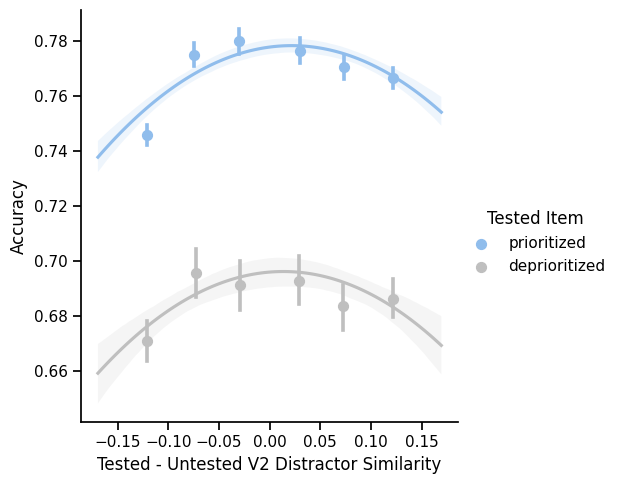

In [11]:


plt.figure(figsize=(10, 6))
sns.lmplot(
    x="Tested - Untested V2 Distractor Similarity",
    y='Accuracy',
    hue = 'Tested Item',
    x_bins = 6,
    order = 2,
    ci = 68,
    data=df
)

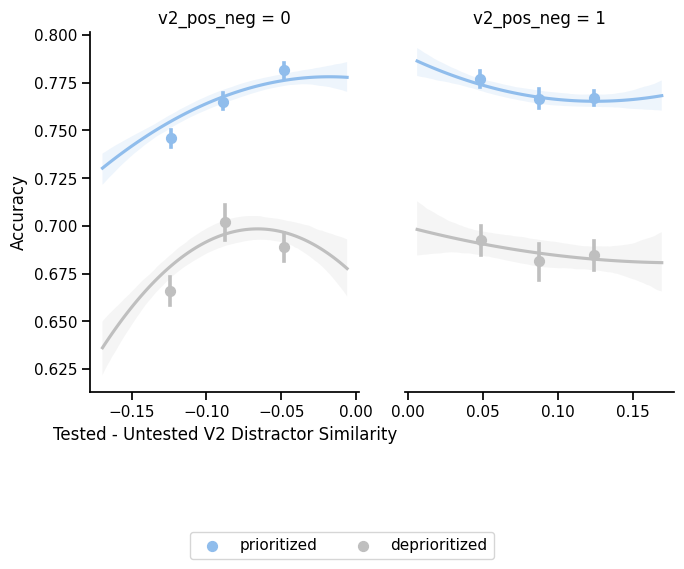

In [12]:
g = sns.lmplot(
    x="Tested - Untested V2 Distractor Similarity",
    y='Accuracy',
    col='v2_pos_neg',
    hue='Tested Item',
    x_bins=3,
    order=2,
    facet_kws={'sharex': False}, 
    ci=68,
    aspect=0.7, 
    data=df,
    legend=False  # Remove the default legend
)

g.axes[0,1].yaxis.set_visible(False)
g.axes[0,1].spines['left'].set_visible(False)
g.axes[0,1].set_xlabel('')

handles, labels = g.axes[0,0].get_legend_handles_labels()

g.fig.legend(handles, labels, loc='lower center', ncol=len(labels), 
             bbox_to_anchor=(0.5, -0.15), frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  

plt.show()

In [13]:
# !pip uninstall seaborn -y
# !pip install seaborn

Total points: 17297, Window size: 3459, Step size: 345


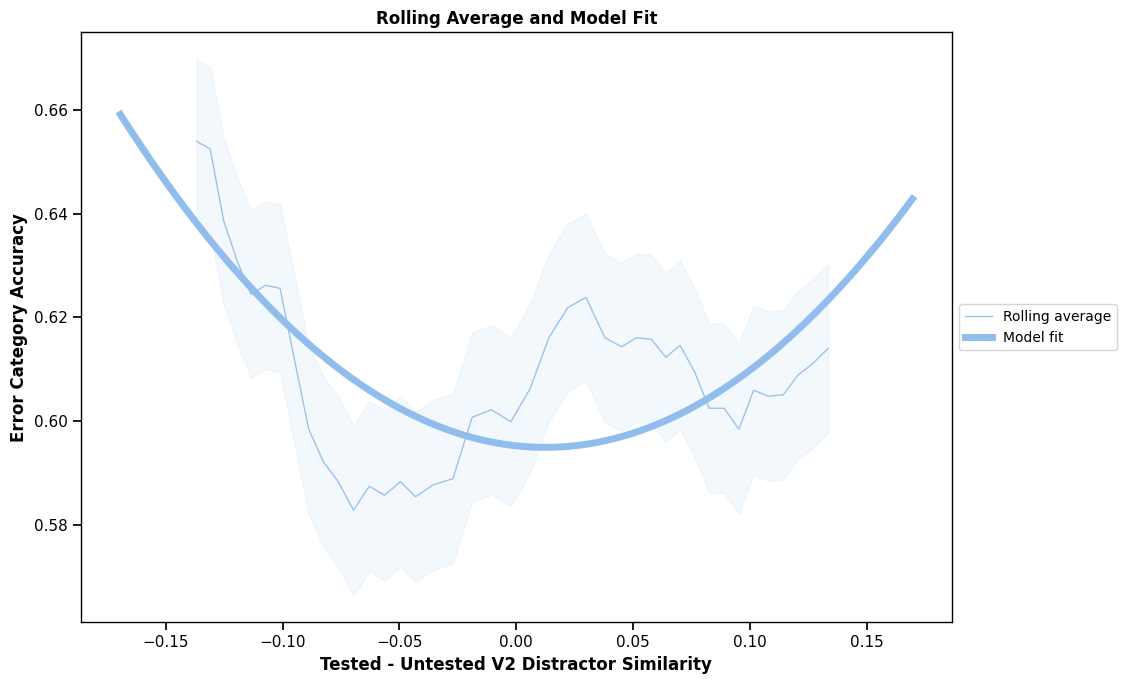

In [14]:
# Call the function
combined_plot = combined_rolling_average_and_model_fit(
    df_cleaned, 
    x_col="Tested - Untested V2 Distractor Similarity",
    y_col="Error Category Accuracy", 
    item_col=None,  # Can be None to avoid splitting
    window_percent=0.2,
    step_percent=0.02,
    palette=palette
)

# Show the plot
plt.show()

Negative side - All Data, Total points: 40353, Window size: 8070, Step size: 403
Positive side - All Data, Total points: 40284, Window size: 8056, Step size: 402


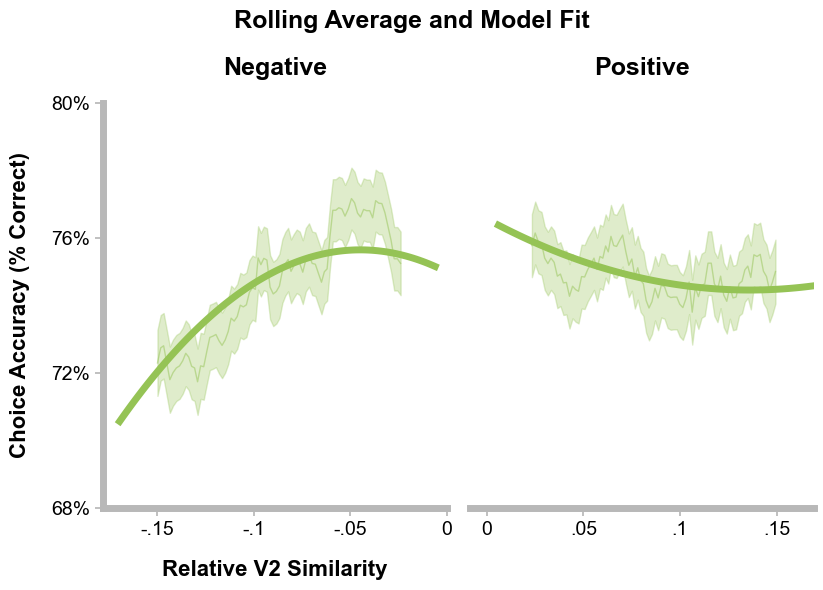

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter, MultipleLocator

def remove_leading_zero_formatter(x, pos):
    """Remove leading zeros from tick labels"""
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def combined_sliding_window_and_model_fit_split_col(df, x_col="Tested - Untested V2 Distractor Similarity", 
                                               y_col='Accuracy', item_col=None,
                                               split_col='v2_pos_neg', split_value=0,
                                               window_percent=0.2, step_percent=0.02,
                                               palette=None, aspect=0.7, figsize_height=6,
                                               # New styling parameters with professional defaults
                                               font_family='Arial',
                                               title_font_size=18, title_font_color='black', title_font_weight='bold',
                                               label_font_size=16, label_font_color='black', label_font_weight='bold',
                                               tick_font_size=14, tick_font_color='black',
                                               rolling_line_width=1, model_line_width=5,
                                               confidence_alpha=0.3, rolling_alpha=0.5,
                                               spine_color='#B8B8B8', spine_width=5,
                                               x_buffer_percent=0.05,
                                               remove_leading_zeros=True,
                                               show_main_title=True,
                                               custom_titles=None,
                                               y_as_percentage=False,
                                               show_legend=False,
                                               y_limits=None,
                                               y_tick_step=None):
    """
    Creates a two-panel plot with data split at split_value of x_col.
    Shows rolling averages and polynomial fits, with option to group by item_col.
    Now includes professional styling matching your second code.
    
    Parameters:
    -----------
    All original parameters plus:
    font_family : str, default 'Arial'
        Font family for all text
    title_font_size, label_font_size, tick_font_size : int
        Font sizes for different elements
    title_font_color, label_font_color, tick_font_color : str
        Colors for different text elements
    rolling_line_width, model_line_width : int
        Line widths for rolling average and model fit lines
    confidence_alpha, rolling_alpha : float
        Transparency levels
    spine_color : str, default '#B8B8B8'
        Color for plot spines
    spine_width : int, default 5
        Width of plot spines
    x_buffer_percent : float, default 0.05
        Buffer space between y-axis and plot data
    remove_leading_zeros : bool, default True
        Whether to remove leading zeros from tick labels
    show_main_title : bool, default True
        Whether to show the main figure title
    custom_titles : dict, optional
        Custom titles for left/right panels, e.g., {'left': 'Negative', 'right': 'Positive'}
    y_as_percentage : bool, default False
        Whether to format y-axis as percentages
    show_legend : bool, default False
        Whether to show the legend
    y_limits : tuple or list, optional
        Y-axis limits as (min, max), e.g., (0.6, 0.8) or [0.6, 0.8]
    y_tick_step : float, optional
        Step size for y-axis ticks, e.g., 0.05 for ticks every 0.05 units
    """
    
    # Set up default palette if none provided
    if palette is None:
        if "IT Distractor Similarity" in x_col:
            default_colors = ['#49a791', '#BFBFBF']  # teal, grey
        elif "V2 Distractor Similarity" in x_col:
            default_colors = ['#95c355', '#BFBFBF']  # green, grey
        else:
            default_colors = ['#1f77b4', '#ff7f0e', '#d62728', '#9467bd', '#8c564b']
    else:
        default_colors = palette
    
    # Color map for specific items
    color_map = {
        'prioritized': default_colors[0],    
        'deprioritized': default_colors[1] if len(default_colors) > 1 else '#BFBFBF',  
    }
    
    # Split the data
    df_left = df[df[x_col] <= split_value].copy()
    df_right = df[df[x_col] > split_value].copy()
    
    # Calculate figure width based on height and aspect ratio
    figsize_width = 2 * figsize_height * aspect  # 2 panels * height * aspect
    
    # Create figure with specified dimensions and professional styling
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(figsize_width, figsize_height), sharey=True)
    fig.patch.set_facecolor('white')
    ax_left.set_facecolor('white')
    ax_right.set_facecolor('white')
    
    # Create a consistent item to color mapping using ALL data (not just one side)
    item_color_dict = {}
    if item_col is not None and item_col in df.columns:
        all_items = df[item_col].unique()
        for i, item in enumerate(all_items):
            item_lower = str(item).lower()
            if item_lower in color_map:
                item_color_dict[item] = color_map[item_lower]
            elif 'prioritized' in item_lower:
                item_color_dict[item] = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                item_color_dict[item] = color_map['deprioritized']
            else:
                item_color_dict[item] = default_colors[i % len(default_colors)]
    
    def process_side(df_side, ax, side_name, group_by_item=True):
        if group_by_item and item_col is not None and item_col in df.columns:
            items = df_side[item_col].unique()
            
            # First, plot rolling averages (in background)
            for i, item in enumerate(items):
                df_item = df_side[df_side[item_col] == item].sort_values(by=x_col).reset_index(drop=True)
                total_points = len(df_item)
                
                window_points = max(int(total_points * window_percent), 3)
                step_points = max(int(total_points * step_percent), 1)
                
                color = item_color_dict.get(item, default_colors[i % len(default_colors)])
                
                if total_points >= window_points:
                    print(f"{side_name} side - {item}, Total points: {total_points}, "
                          f"Window size: {window_points}, Step size: {step_points}")
                        
                    x_vals, y_vals, y_errs = [], [], []
                    
                    for j in range(0, total_points - window_points + 1, step_points):
                        window = df_item.iloc[j:j+window_points]
                        
                        mean_x = window[x_col].mean()
                        mean_y = window[y_col].mean()
                        std_y = window[y_col].std()
                        sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                        
                        x_vals.append(mean_x)
                        y_vals.append(mean_y)
                        y_errs.append(sem_y)
                    
                    x_vals = np.array(x_vals)
                    y_vals = np.array(y_vals)
                    y_errs = np.array(y_errs)
                    
                    if len(x_vals) > 0:
                        # Rolling average with professional styling
                        ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                               alpha=rolling_alpha, label=f'{item} (rolling)')
                        
                        # Confidence bands
                        ax.fill_between(x_vals, 
                                       y_vals - 1.96 * y_errs,
                                       y_vals + 1.96 * y_errs,
                                       color=color, alpha=confidence_alpha)
            
            # Then plot model fits (bold lines on top)
            for i, item in enumerate(items):
                df_item = df_side[df_side[item_col] == item]
                total_points = len(df_item)
                
                color = item_color_dict.get(item, default_colors[i % len(default_colors)])
                
                if total_points >= 5:
                    x_range = np.linspace(df_item[x_col].min(), df_item[x_col].max(), 100)
                    model = np.poly1d(np.polyfit(df_item[x_col], df_item[y_col], 2))
                    
                    # Bold model fit lines
                    ax.plot(x_range, model(x_range), color=color, linestyle='-', 
                            linewidth=model_line_width, label=f'{item} (model)')
        else:
            # Process all data as one group
            df_side = df_side.sort_values(by=x_col).reset_index(drop=True)
            total_points = len(df_side)
            
            window_points = max(int(total_points * window_percent), 3)
            step_points = max(int(total_points * step_percent), 1)
            
            color = default_colors[0]
            
            # Rolling average
            if total_points >= window_points:
                print(f"{side_name} side - All Data, Total points: {total_points}, "
                      f"Window size: {window_points}, Step size: {step_points}")
                    
                x_vals, y_vals, y_errs = [], [], []
                
                for j in range(0, total_points - window_points + 1, step_points):
                    window = df_side.iloc[j:j+window_points]
                    
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    std_y = window[y_col].std()
                    sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                    
                    x_vals.append(mean_x)
                    y_vals.append(mean_y)
                    y_errs.append(sem_y)
                
                x_vals = np.array(x_vals)
                y_vals = np.array(y_vals)
                y_errs = np.array(y_errs)
                
                if len(x_vals) > 0:
                    ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                           alpha=rolling_alpha, label='Rolling average')
                    
                    ax.fill_between(x_vals, 
                                   y_vals - 1.96 * y_errs,
                                   y_vals + 1.96 * y_errs,
                                   color=color, alpha=confidence_alpha)
            
            # Model fit
            if total_points >= 5:
                x_range = np.linspace(df_side[x_col].min(), df_side[x_col].max(), 100)
                model = np.poly1d(np.polyfit(df_side[x_col], df_side[y_col], 2))
                
                ax.plot(x_range, model(x_range), color=color, linestyle='-', 
                        linewidth=model_line_width, label='Model fit')
    
    # Process both sides
    use_item_col = (item_col is not None and item_col in df.columns)
    process_side(df_left, ax_left, "Negative", use_item_col)
    process_side(df_right, ax_right, "Positive", use_item_col)
    
    # Set titles with professional styling
    if custom_titles:
        left_title = custom_titles.get('left', f"{x_col} ≤ {split_value}")
        right_title = custom_titles.get('right', f"{x_col} > {split_value}")
    else:
        left_title = "Negative"
        right_title = "Positive"
    
    ax_left.set_title(left_title, fontsize=title_font_size, 
                     color=title_font_color, fontweight=title_font_weight, 
                     fontfamily=font_family, pad=20)
    ax_right.set_title(right_title, fontsize=title_font_size, 
                      color=title_font_color, fontweight=title_font_weight, 
                      fontfamily=font_family, pad=20)
    
    # Set labels with professional styling
    if "IT Distractor Similarity" in x_col:
        xlabel_text = "Relative IT Similarity"
    elif "V2 Distractor Similarity" in x_col:
        xlabel_text = "Relative V2 Similarity"
    else:
        xlabel_text = x_col
    
    if y_col.lower() in ['accuracy']:
        ylabel_text = "Choice Accuracy (% Correct)"
    elif y_col.lower() in ['wm rt']:
        ylabel_text = "Response Time (msec)"
    else:
        ylabel_text = y_col
    
    ax_left.set_xlabel(xlabel_text, fontweight=label_font_weight, 
                      fontsize=label_font_size, color=label_font_color, 
                      fontfamily=font_family, labelpad=15)
    ax_right.set_xlabel('')  # Remove x-axis label from second subplot
    
    ax_left.set_ylabel(ylabel_text, fontweight=label_font_weight, 
                      fontsize=label_font_size, color=label_font_color, 
                      fontfamily=font_family, labelpad=15)
    
    # Apply professional axis styling
    for ax in [ax_left, ax_right]:
        # Remove grid
        ax.grid(False)
        
        # Style spines with professional colors and widths
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False) 
        ax.spines['bottom'].set_color(spine_color)
        ax.spines['left'].set_color(spine_color)
        ax.spines['bottom'].set_linewidth(spine_width)
        ax.spines['left'].set_linewidth(spine_width)
        
        # Style ticks
        ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, 
                      labelcolor=tick_font_color)
        ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, 
                      labelcolor=tick_font_color)
        
        # Apply font family to all tick labels
        for label in ax.get_xticklabels():
            label.set_fontfamily(font_family)
        for label in ax.get_yticklabels():
            label.set_fontfamily(font_family)
        
        # Apply leading zero removal
        if remove_leading_zeros:
            ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        
        # Apply percentage formatting if requested
        if y_as_percentage:
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
        
        # Set y-axis tick step if specified
        if y_tick_step is not None:
            ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    # Handle y-axis for right plot
    ax_right.set_ylabel('')
    ax_right.tick_params(axis='y', labelleft=False, left=False)
    ax_right.spines['left'].set_visible(False)
    
    # Handle x-limits with buffer space
    if x_buffer_percent > 0:
        # Left side
        data_x_min = df_left[x_col].min() if len(df_left) > 0 else split_value
        x_range_left = abs(split_value - data_x_min)
        buffer_left = x_range_left * x_buffer_percent
        ax_left.set_xlim(data_x_min - buffer_left, split_value)
        
        # Right side  
        data_x_max = df_right[x_col].max() if len(df_right) > 0 else split_value
        x_range_right = abs(data_x_max - split_value)
        buffer_right = x_range_right * x_buffer_percent
        ax_right.set_xlim(split_value - buffer_right, data_x_max)
    
    # Set y-limits
    if y_limits is not None:
        # Use custom y-limits if provided
        ax_left.set_ylim(y_limits)
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct']:
        # Default limits for accuracy plots
        ax_left.set_ylim(0.6, 0.8)
    
    # Create unified legend (optional)
    if show_legend:
        by_label = {}
        for ax in [ax_left, ax_right]:
            handles, labels = ax.get_legend_handles_labels()
            for h, lbl in zip(handles, labels):
                if "(" in lbl:
                    base_label = lbl.split("(")[0].strip()
                else:
                    base_label = lbl
                if base_label not in by_label:
                    by_label[base_label] = h
        
        # Place legend with professional styling
        if by_label:
            fig.legend(by_label.values(), by_label.keys(), 
                      loc='lower center', ncol=len(by_label), 
                      bbox_to_anchor=(0.5, -0.05),
                      fontsize=tick_font_size-2)
    
    # Add main title with professional styling
    if show_main_title:
        title_suffix = f" by {item_col}" if use_item_col else ""
        fig.suptitle(f'Rolling Average and Model Fit{title_suffix}', 
                     fontweight=title_font_weight, fontsize=title_font_size, 
                     y=0.98, color=title_font_color, fontfamily=font_family)
    
    plt.tight_layout()
    if show_legend:
        plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    return fig


# Example with custom y-axis control:
fig3 = combined_sliding_window_and_model_fit_split_col(
    df, 
    x_col="Tested - Untested V2 Distractor Similarity",
    y_col="Accuracy", 
    item_col=None,  
    split_col="v2_pos_neg",
    split_value=0,
    window_percent=0.2,     # Smaller rolling window
    step_percent=0.01,       # Finer steps
    palette=[v2_col, grey],
    y_limits=[0.68, 0.8],     # Custom y-axis range
    y_tick_step=0.04,         # Y-ticks every 0.1
    y_as_percentage=True     # Show as percentages
)
plt.show()


In [36]:



grey = '#BFBFBF'
blue = '#6cbcef'
it_col = '#49a791'
v2_col_ltm = '#a271b1'
it_col_ltm = '#E52A72'
gold = '#dbad40'
v2_col = '#95c355'

In [43]:
# # Call with aspect ratio of 0.7
# fig = combined_sliding_window_and_model_fit_split_col(
#     df_cleaned, 
#     x_col="Tested - Untested IT Distractor Similarity",
#     y_col="Error Category Accuracy", 

#     # item_col="Tested Item",
#     split_col="IT_pos_neg",
#     split_value=0,
#     window_percent=0.2, 
#     step_percent=0.02,
#     # palette=['#90BDEC', '#BFBFBF'],
#     aspect=0.7  # Set aspect ratio to 0.7
# )

# plt.show()

# fig2 = combined_sliding_window_and_model_fit_split_col(
#     df, 
#     x_col="Tested - Untested V2 Distractor Similarity",
#     y_col="Accuracy", 
#     item_col=None,  
#     split_col="v2_pos_neg",
#     split_value=0,
#     window_percent=0.2, 
#     step_percent=0.02,
#     palette=[v2_col, grey]
# )

# plt.show()


fig, ax = configurable_rolling_average_and_model_fit(
    df=df,
    x_col="Tested - Untested V2 Distractor Similarity",
    y_col="Accuracy", 
    config_dict=my_config
)
plt.show()

NameError: name 'my_config' is not defined

In [42]:
{
  "figure": {
    "figsize": [14, 8],
    "facecolor": "white",
    "dpi": 100
  },
  "title": {
    "text": "Similarity Analysis: Rolling Averages and Model Fits",
    "fontsize": 20,
    "fontweight": "bold",
    "fontcolor": "black",
    "fontfamily": "Arial",
    "pad": 25,
    "show": True
  },
  "axes": {
    "facecolor": "white",
    "grid": False,
    "spine_color": "#B8B8B8",
    "spine_width": 5
  },
  "xlabel": {
    "text": "",
    "fontsize": 18,
    "fontweight": "bold",
    "fontcolor": "black",
    "fontfamily": "Arial",
    "labelpad": 15
  },
  "ylabel": {
    "text": "",
    "fontsize": 18,
    "fontweight": "bold",
    "fontcolor": "black",
    "fontfamily": "Arial",
    "labelpad": 15
  },
  "ticks": {
    "fontsize": 16,
    "fontcolor": "black",
    "fontfamily": "Arial",
    "color": "#B8B8B8",
    "x_step": 0.1,
    "y_step": 0.05,
    "remove_leading_zeros": True
  },
  "legend": {
    "show": True,
    "fontsize": 12,
    "loc": "center left",
    "bbox_to_anchor": [1.0, 0.5],
    "frameon": True
  },
  "rolling_average": {
    "window_percent": 0.15,
    "step_percent": 0.01,
    "line_width": 2,
    "alpha": 0.8,
    "confidence_alpha": 0.15,
    "show_confidence": True
  },
  "model_fit": {
    "line_width": 6,
    "polynomial_order": 2,
    "alpha": 1.0,
    "linestyle": "-"
  },
  "colors": {
    "palette_type": "auto",
    "custom_palette": ["#49a791", "#95c355", "#e58a72", "#a271b1", "#dbad40"],
    "it_similarity": ["#49a791"],
    "v2_similarity": ["#95c355"],
    "prioritized": "#49a791",
    "deprioritized": "#BFBFBF"
  },
  "limits": {
    "x_limits": [-0.8, 0.8],
    "y_limits": "",
    "auto_y_for_accuracy": True,
    "accuracy_y_limits": [0.6, 0.8]
  },
  "layout": {
    "tight_layout": True,
    "adjust_right": 0.82
  },
  "percentage_formatting": {
    "y_as_percentage": False,
    "percentage_step": 5
  }
}

{'figure': {'figsize': [14, 8], 'facecolor': 'white', 'dpi': 100},
 'title': {'text': 'Similarity Analysis: Rolling Averages and Model Fits',
  'fontsize': 20,
  'fontweight': 'bold',
  'fontcolor': 'black',
  'fontfamily': 'Arial',
  'pad': 25,
  'show': True},
 'axes': {'facecolor': 'white',
  'grid': False,
  'spine_color': '#B8B8B8',
  'spine_width': 5},
 'xlabel': {'text': '',
  'fontsize': 18,
  'fontweight': 'bold',
  'fontcolor': 'black',
  'fontfamily': 'Arial',
  'labelpad': 15},
 'ylabel': {'text': '',
  'fontsize': 18,
  'fontweight': 'bold',
  'fontcolor': 'black',
  'fontfamily': 'Arial',
  'labelpad': 15},
 'ticks': {'fontsize': 16,
  'fontcolor': 'black',
  'fontfamily': 'Arial',
  'color': '#B8B8B8',
  'x_step': 0.1,
  'y_step': 0.05,
  'remove_leading_zeros': True},
 'legend': {'show': True,
  'fontsize': 12,
  'loc': 'center left',
  'bbox_to_anchor': [1.0, 0.5],
  'frameon': True},
 'rolling_average': {'window_percent': 0.15,
  'step_percent': 0.01,
  'line_width': 

<Figure size 1000x600 with 0 Axes>

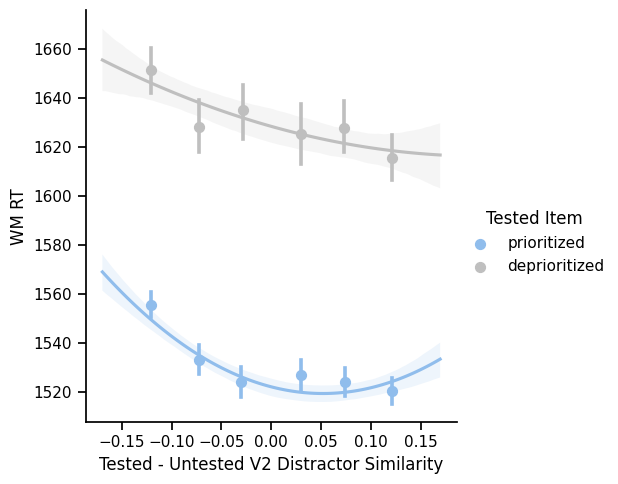

In [17]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x="Tested - Untested V2 Distractor Similarity",
    y='WM RT',
    hue = "Tested Item",
    x_bins = 6,
    order = 2,
    ci = 68,
    data=df_correct
)

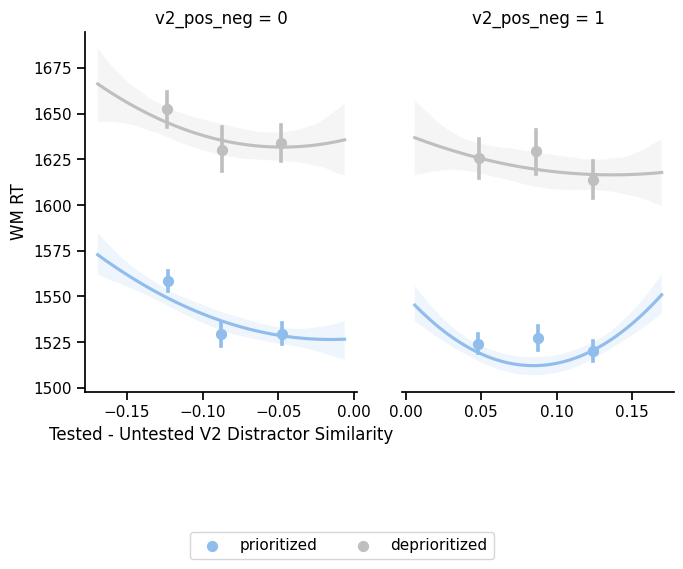

In [18]:
g = sns.lmplot(
    x="Tested - Untested V2 Distractor Similarity",
    y='WM RT',
    col='v2_pos_neg',
    hue = "Tested Item",
    x_bins=3,
    order=2,
    facet_kws={'sharex': False}, 
    ci=68,
    aspect=0.7, 
    data=df_correct,
    legend=False  
)
g.axes[0,1].yaxis.set_visible(False)
g.axes[0,1].spines['left'].set_visible(False)
g.axes[0,1].set_xlabel('')
handles, labels = g.axes[0,0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='lower center', ncol=len(labels), 
             bbox_to_anchor=(0.5, -0.15), frameon=True)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  
plt.show()

Item: prioritized, Total points: 46401, Window size: 9280, Step size: 928
Item: deprioritized, Total points: 13818, Window size: 2763, Step size: 276


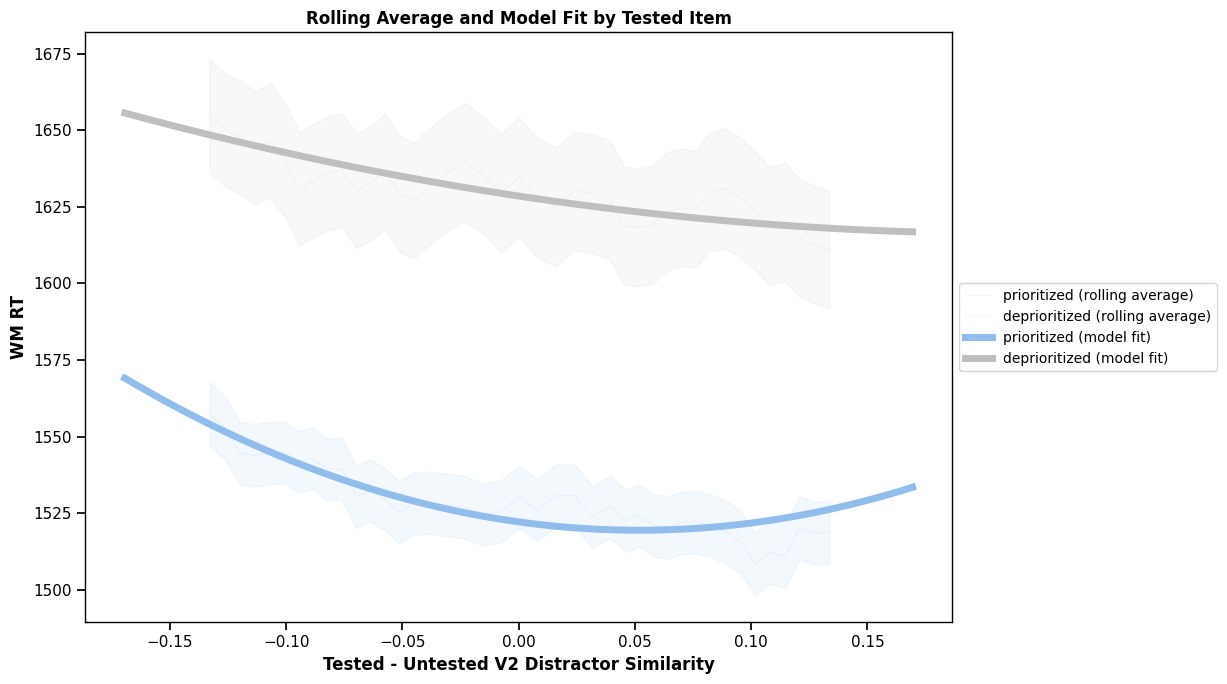

In [19]:
combined_plot = combined_rolling_average_and_model_fit(
    df_correct, 
    x_col="Tested - Untested V2 Distractor Similarity",
    y_col="WM RT",
    item_col="Tested Item",  # Can be None to avoid splitting
    window_percent=0.2,
    step_percent=0.02,
    palette=palette
)

plt.show()

In [20]:
fig2 = combined_sliding_window_and_model_fit_split_col_subplot(
    df, 
    x_col="Tested - Untested IT Distractor Similarity",
    y_col="Accuracy", 
    item_col="Tested Item",  # No grouping by item
    split_col="IT_pos_neg",
    split_value=0,
    window_percent=0.2, 
    step_percent=0.02,
    palette=['#90BDEC', '#BFBFBF']  # Your custom palette
)

plt.show()

NameError: name 'combined_sliding_window_and_model_fit_split_col_subplot' is not defined

In [ ]:
df_cleaned['WM Wrong Category'] = np.where(
    df_cleaned['last_clicked_category'] == 'wrong_category',
    'True',
    'False'
)
df_cleaned['wm_wrong_category'] = df_cleaned['WM Wrong Category']

df_cleaned['wm_wrong_category_num'] =  np.where(
    df_cleaned['wm_wrong_category'] == "True", 1,0 )
df_cleaned['wm_wrong_category_num'].unique()


In [ ]:
df_cleaned['Wrong Category'] = df_cleaned['wm_wrong_category_num']

In [ ]:
df_cleaned['Wrong Category']